# A Vision Transformer without Attention

**Author:** [Aritra Roy Gosthipaty](https://twitter.com/ariG23498), [Ritwik Raha](https://twitter.com/ritwik_raha), [Shivalika Singh](https://www.linkedin.com/in/shivalika-singh/)<br>
**Date created:** 2022/02/24<br>
**Last modified:** 2022/10/15<br>
**Description:** A minimal implementation of ShiftViT.

## Introduction

[Vision Transformers](https://arxiv.org/abs/2010.11929) (ViTs) have sparked a wave of
research at the intersection of Transformers and Computer Vision (CV).

ViTs can simultaneously model long- and short-range dependencies, thanks to
the Multi-Head Self-Attention mechanism in the Transformer block. Many researchers believe
that the success of ViTs are purely due to the attention layer, and they seldom
think about other parts of the ViT model.

In the academic paper
[When Shift Operation Meets Vision Transformer: An Extremely Simple Alternative to Attention Mechanism](https://arxiv.org/abs/2201.10801)
the authors propose to demystify the success of ViTs with the introduction of a **NO
PARAMETER** operation in place of the attention operation. They swap the attention
operation with a shifting operation.

In this example, we minimally implement the paper with close alignement to the author's
[official implementation](https://github.com/microsoft/SPACH/blob/main/models/shiftvit.py).

This example requires TensorFlow 2.9 or higher, as well as TensorFlow Addons, which can
be installed using the following command:

In [1]:
!pip install -qq -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.8 MB/s eta 0:00:00


## Setup and imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import pathlib
import glob

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Hyperparameters

These are the hyperparameters that we have chosen for the experiment.
Please feel free to tune them.

In [3]:

class Config(object):
    # DATA
    batch_size = 256
    buffer_size = batch_size * 2
    input_shape = (32, 32, 3)
    num_classes = 10

    # AUGMENTATION
    image_size = 48

    # ARCHITECTURE
    patch_size = 4
    projected_dim = 96
    num_shift_blocks_per_stages = [2, 4, 8, 2]
    epsilon = 1e-5
    stochastic_depth_rate = 0.2
    mlp_dropout_rate = 0.2
    num_div = 12
    shift_pixel = 1
    mlp_expand_ratio = 2

    # OPTIMIZER
    lr_start = 1e-5
    lr_max = 1e-3
    weight_decay = 1e-4

    # TRAINING
    epochs = 100

    # INFERENCE
    label_map = {
        0: "airplane",
        1: "automobile",
        2: "bird",
        3: "cat",
        4: "deer",
        5: "dog",
        6: "frog",
        7: "horse",
        8: "ship",
        9: "truck",
    }
    tf_ds_batch_size = 20


config = Config()

## Load the CIFAR-10 dataset

We use the CIFAR-10 dataset for our experiments.

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

AUTO = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(config.buffer_size).batch(config.batch_size).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(config.batch_size).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(config.batch_size).prefetch(AUTO)

170498071/170498071 [==============================] - 4s 0us/step
Training samples: 40000
Validation samples: 10000
Testing samples: 10000


## Data Augmentation

The augmentation pipeline consists of:

- Rescaling
- Resizing
- Random cropping
- Random horizontal flipping

_Note_: The image data augmentation layers do not apply
data transformations at inference time. This means that
when these layers are called with `training=False` they
behave differently. Refer to the
[documentation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/)
for more details.

In [5]:

def get_augmentation_model():
    """Build the data augmentation model."""
    data_augmentation = keras.Sequential(
        [
            layers.Resizing(config.input_shape[0] + 20, config.input_shape[0] + 20),
            layers.RandomCrop(config.image_size, config.image_size),
            layers.RandomFlip("horizontal"),
            layers.Rescaling(1 / 255.0),
        ]
    )
    return data_augmentation


## The ShiftViT architecture

In this section, we build the architecture proposed in
[the ShiftViT paper](https://arxiv.org/abs/2201.10801).

| ![ShiftViT Architecture](https://i.imgur.com/CHU40HX.png) |
| :--: |
| Figure 1: The entire architecutre of ShiftViT.
[Source](https://arxiv.org/abs/2201.10801) |

The architecture as shown in Fig. 1, is inspired by
[Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030).
Here the authors propose a modular architecture with 4 stages. Each stage works on its
own spatial size, creating a hierarchical architecture.

An input image of size `HxWx3` is split into non-overlapping patches of size `4x4`.
This is done via the patchify layer which results in individual tokens of feature size `48`
(`4x4x3`). Each stage comprises two parts:

1. Embedding Generation
2. Stacked Shift Blocks

We discuss the stages and the modules in detail in what follows.

_Note_: Compared to the [official implementation](https://github.com/microsoft/SPACH/blob/main/models/shiftvit.py)
we restructure some key components to better fit the Keras API.

### The ShiftViT Block

| ![ShiftViT block](https://i.imgur.com/IDe35vo.gif) |
| :--: |
| Figure 2: From the Model to a Shift Block. |

Each stage in the ShiftViT architecture comprises of a Shift Block as shown in Fig 2.

| ![Shift Vit Block](https://i.imgur.com/0q13pLu.png) |
| :--: |
| Figure 3: The Shift ViT Block. [Source](https://arxiv.org/abs/2201.10801) |

The Shift Block as shown in Fig. 3, comprises of the following:

1. Shift Operation
2. Linear Normalization
3. MLP Layer

#### The MLP block

The MLP block is intended to be a stack of densely-connected layers

In [6]:

class MLP(layers.Layer):
    """Get the MLP layer for each shift block.

    Args:
        mlp_expand_ratio (int): The ratio with which the first feature map is expanded.
        mlp_dropout_rate (float): The rate for dropout.
    """

    def __init__(self, mlp_expand_ratio, mlp_dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.mlp_expand_ratio = mlp_expand_ratio
        self.mlp_dropout_rate = mlp_dropout_rate

    def build(self, input_shape):
        input_channels = input_shape[-1]
        initial_filters = int(self.mlp_expand_ratio * input_channels)

        self.mlp = keras.Sequential(
            [
                layers.Dense(
                    units=initial_filters,
                    activation=tf.nn.gelu,
                ),
                layers.Dropout(rate=self.mlp_dropout_rate),
                layers.Dense(units=input_channels),
                layers.Dropout(rate=self.mlp_dropout_rate),
            ]
        )

    def call(self, x):
        x = self.mlp(x)
        return x


#### The DropPath layer

Stochastic depth is a regularization technique that randomly drops a set of
layers. During inference, the layers are kept as they are. It is very
similar to Dropout, but it operates on a block of layers rather
than on individual nodes present inside a layer.

In [7]:

class DropPath(layers.Layer):
    """Drop Path also known as the Stochastic Depth layer.

    Refernece:
        - https://keras.io/examples/vision/cct/#stochastic-depth-for-regularization
        - github.com:rwightman/pytorch-image-models
    """

    def __init__(self, drop_path_prob, **kwargs):
        super().__init__(**kwargs)
        self.drop_path_prob = drop_path_prob

    def call(self, x, training=False):
        if training:
            keep_prob = 1 - self.drop_path_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


#### Block

The most important operation in this paper is the **shift operation**. In this section,
we describe the shift operation and compare it with its original implementation provided
by the authors.

A generic feature map is assumed to have the shape `[N, H, W, C]`. Here we choose a
`num_div` parameter that decides the division size of the channels. The first 4 divisions
are shifted (1 pixel) in the left, right, up, and down direction. The remaining splits
are kept as is. After partial shifting the shifted channels are padded and the overflown
pixels are chopped off. This completes the partial shifting operation.

In the original implementation, the code is approximately:

```python
out[:, g * 0:g * 1, :, :-1] = x[:, g * 0:g * 1, :, 1:]  # shift left
out[:, g * 1:g * 2, :, 1:] = x[:, g * 1:g * 2, :, :-1]  # shift right
out[:, g * 2:g * 3, :-1, :] = x[:, g * 2:g * 3, 1:, :]  # shift up
out[:, g * 3:g * 4, 1:, :] = x[:, g * 3:g * 4, :-1, :]  # shift down

out[:, g * 4:, :, :] = x[:, g * 4:, :, :]  # no shift
```

In TensorFlow it would be infeasible for us to assign shifted channels to a tensor in the
middle of the training process. This is why we have resorted to the following procedure:

1. Split the channels with the `num_div` parameter.
2. Select each of the first four spilts and shift and pad them in the respective
directions.
3. After shifting and padding, we concatenate the channel back.

| ![Manim rendered animation for shift operation](https://i.imgur.com/PReeULP.gif) |
| :--: |
| Figure 4: The TensorFlow style shifting |

The entire procedure is explained in the Fig. 4.

In [8]:

class ShiftViTBlock(layers.Layer):
    """A unit ShiftViT Block

    Args:
        shift_pixel (int): The number of pixels to shift. Default to 1.
        mlp_expand_ratio (int): The ratio with which MLP features are
            expanded. Default to 2.
        mlp_dropout_rate (float): The dropout rate used in MLP.
        num_div (int): The number of divisions of the feature map's channel.
            Totally, 4/num_div of channels will be shifted. Defaults to 12.
        epsilon (float): Epsilon constant.
        drop_path_prob (float): The drop probability for drop path.
    """

    def __init__(
        self,
        epsilon,
        drop_path_prob,
        mlp_dropout_rate,
        num_div=12,
        shift_pixel=1,
        mlp_expand_ratio=2,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.shift_pixel = shift_pixel
        self.mlp_expand_ratio = mlp_expand_ratio
        self.mlp_dropout_rate = mlp_dropout_rate
        self.num_div = num_div
        self.epsilon = epsilon
        self.drop_path_prob = drop_path_prob

    def build(self, input_shape):
        self.H = input_shape[1]
        self.W = input_shape[2]
        self.C = input_shape[3]
        self.layer_norm = layers.LayerNormalization(epsilon=self.epsilon)
        self.drop_path = (
            DropPath(drop_path_prob=self.drop_path_prob)
            if self.drop_path_prob > 0.0
            else layers.Activation("linear")
        )
        self.mlp = MLP(
            mlp_expand_ratio=self.mlp_expand_ratio,
            mlp_dropout_rate=self.mlp_dropout_rate,
        )

    def get_shift_pad(self, x, mode):
        """Shifts the channels according to the mode chosen."""
        if mode == "left":
            offset_height = 0
            offset_width = 0
            target_height = 0
            target_width = self.shift_pixel
        elif mode == "right":
            offset_height = 0
            offset_width = self.shift_pixel
            target_height = 0
            target_width = self.shift_pixel
        elif mode == "up":
            offset_height = 0
            offset_width = 0
            target_height = self.shift_pixel
            target_width = 0
        else:
            offset_height = self.shift_pixel
            offset_width = 0
            target_height = self.shift_pixel
            target_width = 0
        crop = tf.image.crop_to_bounding_box(
            x,
            offset_height=offset_height,
            offset_width=offset_width,
            target_height=self.H - target_height,
            target_width=self.W - target_width,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=offset_height,
            offset_width=offset_width,
            target_height=self.H,
            target_width=self.W,
        )
        return shift_pad

    def call(self, x, training=False):
        # Split the feature maps
        x_splits = tf.split(x, num_or_size_splits=self.C // self.num_div, axis=-1)

        # Shift the feature maps
        x_splits[0] = self.get_shift_pad(x_splits[0], mode="left")
        x_splits[1] = self.get_shift_pad(x_splits[1], mode="right")
        x_splits[2] = self.get_shift_pad(x_splits[2], mode="up")
        x_splits[3] = self.get_shift_pad(x_splits[3], mode="down")

        # Concatenate the shifted and unshifted feature maps
        x = tf.concat(x_splits, axis=-1)

        # Add the residual connection
        shortcut = x
        x = shortcut + self.drop_path(self.mlp(self.layer_norm(x)), training=training)
        return x


### The ShiftViT blocks

| ![Shift Blokcs](https://i.imgur.com/FKy5NnD.png) |
| :--: |
| Figure 5: Shift Blocks in the architecture. [Source](https://arxiv.org/abs/2201.10801) |

Each stage of the architecture has shift blocks as shown in Fig.5. Each of these blocks
contain a variable number of stacked ShiftViT block (as built in the earlier section).

Shift blocks are followed by a PatchMerging layer that scales down feature inputs. The
PatchMerging layer helps in the pyramidal structure of the model.

#### The PatchMerging layer

This layer merges the two adjacent tokens. This layer helps in scaling the features down
spatially and increasing the features up channel wise. We use a Conv2D layer to merge the
patches.

In [9]:

class PatchMerging(layers.Layer):
    """The Patch Merging layer.

    Args:
        epsilon (float): The epsilon constant.
    """

    def __init__(self, epsilon, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        filters = 2 * input_shape[-1]
        self.reduction = layers.Conv2D(
            filters=filters, kernel_size=2, strides=2, padding="same", use_bias=False
        )
        self.layer_norm = layers.LayerNormalization(epsilon=self.epsilon)

    def call(self, x):
        # Apply the patch merging algorithm on the feature maps
        x = self.layer_norm(x)
        x = self.reduction(x)
        return x


#### Stacked Shift Blocks

Each stage will have a variable number of stacked ShiftViT Blocks, as suggested in
the paper. This is a generic layer that will contain the stacked shift vit blocks
with the patch merging layer as well. Combining the two operations (shift ViT
block and patch merging) is a design choice we picked for better code reusability.

In [10]:
# Note: This layer will have a different depth of stacking
# for different stages on the model.
class StackedShiftBlocks(layers.Layer):
    """The layer containing stacked ShiftViTBlocks.

    Args:
        epsilon (float): The epsilon constant.
        mlp_dropout_rate (float): The dropout rate used in the MLP block.
        num_shift_blocks (int): The number of shift vit blocks for this stage.
        stochastic_depth_rate (float): The maximum drop path rate chosen.
        is_merge (boolean): A flag that determines the use of the Patch Merge
            layer after the shift vit blocks.
        num_div (int): The division of channels of the feature map. Defaults to 12.
        shift_pixel (int): The number of pixels to shift. Defaults to 1.
        mlp_expand_ratio (int): The ratio with which the initial dense layer of
            the MLP is expanded Defaults to 2.
    """

    def __init__(
        self,
        epsilon,
        mlp_dropout_rate,
        num_shift_blocks,
        stochastic_depth_rate,
        is_merge,
        num_div=12,
        shift_pixel=1,
        mlp_expand_ratio=2,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.mlp_dropout_rate = mlp_dropout_rate
        self.num_shift_blocks = num_shift_blocks
        self.stochastic_depth_rate = stochastic_depth_rate
        self.is_merge = is_merge
        self.num_div = num_div
        self.shift_pixel = shift_pixel
        self.mlp_expand_ratio = mlp_expand_ratio

    def build(self, input_shapes):
        # Calculate stochastic depth probabilities.
        # Reference: https://keras.io/examples/vision/cct/#the-final-cct-model
        dpr = [
            x
            for x in np.linspace(
                start=0, stop=self.stochastic_depth_rate, num=self.num_shift_blocks
            )
        ]

        # Build the shift blocks as a list of ShiftViT Blocks
        self.shift_blocks = list()
        for num in range(self.num_shift_blocks):
            self.shift_blocks.append(
                ShiftViTBlock(
                    num_div=self.num_div,
                    epsilon=self.epsilon,
                    drop_path_prob=dpr[num],
                    mlp_dropout_rate=self.mlp_dropout_rate,
                    shift_pixel=self.shift_pixel,
                    mlp_expand_ratio=self.mlp_expand_ratio,
                )
            )
        if self.is_merge:
            self.patch_merge = PatchMerging(epsilon=self.epsilon)

    def call(self, x, training=False):
        for shift_block in self.shift_blocks:
            x = shift_block(x, training=training)
        if self.is_merge:
            x = self.patch_merge(x)
        return x

    # Since this is a custom layer, we need to overwrite get_config()
    # so that model can be easily saved & loaded after training
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "epsilon": self.epsilon,
                "mlp_dropout_rate": self.mlp_dropout_rate,
                "num_shift_blocks": self.num_shift_blocks,
                "stochastic_depth_rate": self.stochastic_depth_rate,
                "is_merge": self.is_merge,
                "num_div": self.num_div,
                "shift_pixel": self.shift_pixel,
                "mlp_expand_ratio": self.mlp_expand_ratio,
            }
        )
        return config


## The ShiftViT model

Build the ShiftViT custom model.

In [11]:

class ShiftViTModel(keras.Model):
    """The ShiftViT Model.

    Args:
        data_augmentation (keras.Model): A data augmentation model.
        projected_dim (int): The dimension to which the patches of the image are
            projected.
        patch_size (int): The patch size of the images.
        num_shift_blocks_per_stages (list[int]): A list of all the number of shit
            blocks per stage.
        epsilon (float): The epsilon constant.
        mlp_dropout_rate (float): The dropout rate used in the MLP block.
        stochastic_depth_rate (float): The maximum drop rate probability.
        num_div (int): The number of divisions of the channesl of the feature
            map. Defaults to 12.
        shift_pixel (int): The number of pixel to shift. Default to 1.
        mlp_expand_ratio (int): The ratio with which the initial mlp dense layer
            is expanded to. Defaults to 2.
    """

    def __init__(
        self,
        data_augmentation,
        projected_dim,
        patch_size,
        num_shift_blocks_per_stages,
        epsilon,
        mlp_dropout_rate,
        stochastic_depth_rate,
        num_div=12,
        shift_pixel=1,
        mlp_expand_ratio=2,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.data_augmentation = data_augmentation
        self.patch_projection = layers.Conv2D(
            filters=projected_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="same",
        )
        self.stages = list()
        for index, num_shift_blocks in enumerate(num_shift_blocks_per_stages):
            if index == len(num_shift_blocks_per_stages) - 1:
                # This is the last stage, do not use the patch merge here.
                is_merge = False
            else:
                is_merge = True
            # Build the stages.
            self.stages.append(
                StackedShiftBlocks(
                    epsilon=epsilon,
                    mlp_dropout_rate=mlp_dropout_rate,
                    num_shift_blocks=num_shift_blocks,
                    stochastic_depth_rate=stochastic_depth_rate,
                    is_merge=is_merge,
                    num_div=num_div,
                    shift_pixel=shift_pixel,
                    mlp_expand_ratio=mlp_expand_ratio,
                )
            )
        self.global_avg_pool = layers.GlobalAveragePooling2D()

        self.classifier = layers.Dense(config.num_classes)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "data_augmentation": self.data_augmentation,
                "patch_projection": self.patch_projection,
                "stages": self.stages,
                "global_avg_pool": self.global_avg_pool,
                "classifier": self.classifier,
            }
        )
        return config

    def _calculate_loss(self, data, training=False):
        (images, labels) = data

        # Augment the images
        augmented_images = self.data_augmentation(images, training=training)

        # Create patches and project the pathces.
        projected_patches = self.patch_projection(augmented_images)

        # Pass through the stages
        x = projected_patches
        for stage in self.stages:
            x = stage(x, training=training)

        # Get the logits.
        x = self.global_avg_pool(x)
        logits = self.classifier(x)

        # Calculate the loss and return it.
        total_loss = self.compiled_loss(labels, logits)
        return total_loss, labels, logits

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            total_loss, labels, logits = self._calculate_loss(
                data=inputs, training=True
            )

        # Apply gradients.
        train_vars = [
            self.data_augmentation.trainable_variables,
            self.patch_projection.trainable_variables,
            self.global_avg_pool.trainable_variables,
            self.classifier.trainable_variables,
        ]
        train_vars = train_vars + [stage.trainable_variables for stage in self.stages]

        # Optimize the gradients.
        grads = tape.gradient(total_loss, train_vars)
        trainable_variable_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                trainable_variable_list.append((g, v))
        self.optimizer.apply_gradients(trainable_variable_list)

        # Update the metrics
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        _, labels, logits = self._calculate_loss(data=data, training=False)

        # Update the metrics
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def call(self, images):
        augmented_images = self.data_augmentation(images)
        x = self.patch_projection(augmented_images)
        for stage in self.stages:
            x = stage(x, training=False)
        x = self.global_avg_pool(x)
        logits = self.classifier(x)
        return logits


## Instantiate the model

In [12]:
model = ShiftViTModel(
    data_augmentation=get_augmentation_model(),
    projected_dim=config.projected_dim,
    patch_size=config.patch_size,
    num_shift_blocks_per_stages=config.num_shift_blocks_per_stages,
    epsilon=config.epsilon,
    mlp_dropout_rate=config.mlp_dropout_rate,
    stochastic_depth_rate=config.stochastic_depth_rate,
    num_div=config.num_div,
    shift_pixel=config.shift_pixel,
    mlp_expand_ratio=config.mlp_expand_ratio,
)

## Learning rate schedule

In many experiments, we want to warm up the model with a slowly increasing learning rate
and then cool down the model with a slowly decaying learning rate. In the warmup cosine
decay, the learning rate linearly increases for the warmup steps and then decays with a
cosine decay.

In [13]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    """A LearningRateSchedule that uses a warmup cosine decay schedule."""

    def __init__(self, lr_start, lr_max, warmup_steps, total_steps):
        """
        Args:
            lr_start: The initial learning rate
            lr_max: The maximum learning rate to which lr should increase to in
                the warmup steps
            warmup_steps: The number of steps for which the model warms up
            total_steps: The total number of steps for the model training
        """
        super().__init__()
        self.lr_start = lr_start
        self.lr_max = lr_max
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        # Check whether the total number of steps is larger than the warmup
        # steps. If not, then throw a value error.
        if self.total_steps < self.warmup_steps:
            raise ValueError(
                f"Total number of steps {self.total_steps} must be"
                + f"larger or equal to warmup steps {self.warmup_steps}."
            )

        # `cos_annealed_lr` is a graph that increases to 1 from the initial
        # step to the warmup step. After that this graph decays to -1 at the
        # final step mark.
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / tf.cast(self.total_steps - self.warmup_steps, tf.float32)
        )

        # Shift the mean of the `cos_annealed_lr` graph to 1. Now the grpah goes
        # from 0 to 2. Normalize the graph with 0.5 so that now it goes from 0
        # to 1. With the normalized graph we scale it with `lr_max` such that
        # it goes from 0 to `lr_max`
        learning_rate = 0.5 * self.lr_max * (1 + cos_annealed_lr)

        # Check whether warmup_steps is more than 0.
        if self.warmup_steps > 0:
            # Check whether lr_max is larger that lr_start. If not, throw a value
            # error.
            if self.lr_max < self.lr_start:
                raise ValueError(
                    f"lr_start {self.lr_start} must be smaller or"
                    + f"equal to lr_max {self.lr_max}."
                )

            # Calculate the slope with which the learning rate should increase
            # in the warumup schedule. The formula for slope is m = ((b-a)/steps)
            slope = (self.lr_max - self.lr_start) / self.warmup_steps

            # With the formula for a straight line (y = mx+c) build the warmup
            # schedule
            warmup_rate = slope * tf.cast(step, tf.float32) + self.lr_start

            # When the current step is lesser that warmup steps, get the line
            # graph. When the current step is greater than the warmup steps, get
            # the scaled cos graph.
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )

        # When the current step is more that the total steps, return 0 else return
        # the calculated graph.
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

    def get_config(self):
        config = {
            "lr_start": self.lr_start,
            "lr_max": self.lr_max,
            "total_steps": self.total_steps,
            "warmup_steps": self.warmup_steps,
        }
        return config


## Compile and train the model

In [14]:
# pass sample data to the model so that input shape is available at the time of
# saving the model
sample_ds, _ = next(iter(train_ds))
model(sample_ds, training=False)

# Get the total number of steps for training.
total_steps = int((len(x_train) / config.batch_size) * config.epochs)

# Calculate the number of steps for warmup.
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)

# Initialize the warmupcosine schedule.
scheduled_lrs = WarmUpCosine(
    lr_start=1e-5,
    lr_max=1e-3,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
)

# Get the optimizer.
optimizer = tfa.optimizers.AdamW(
    learning_rate=scheduled_lrs, weight_decay=config.weight_decay
)

# Compile and pretrain the model.
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

# Train the model
history = model.fit(
    train_ds,
    epochs=config.epochs,
    validation_data=val_ds,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=5,
            mode="auto",
        )
    ],
)

# Evaluate the model with the test dataset.
print("TESTING")
loss, acc_top1, acc_top5 = model.evaluate(test_ds)
print(f"Loss: {loss:0.2f}")
print(f"Top 1 test accuracy: {acc_top1*100:0.2f}%")
print(f"Top 5 test accuracy: {acc_top5*100:0.2f}%")

Epoch 1/100
157/157 [==============================] - 52s 191ms/step - loss: 2.3725 - accuracy: 0.1493 - top-5-accuracy: 0.6082 - val_loss: 2.1262 - val_accuracy: 0.2647 - val_top-5-accuracy: 0.7758
Epoch 2/100
157/157 [==============================] - 26s 166ms/step - loss: 1.9447 - accuracy: 0.2919 - top-5-accuracy: 0.8089 - val_loss: 1.9171 - val_accuracy: 0.3461 - val_top-5-accuracy: 0.8727
Epoch 3/100
157/157 [==============================] - 26s 167ms/step - loss: 1.7015 - accuracy: 0.3846 - top-5-accuracy: 0.8764 - val_loss: 1.5880 - val_accuracy: 0.4434 - val_top-5-accuracy: 0.9021
Epoch 4/100
157/157 [==============================] - 26s 167ms/step - loss: 1.5642 - accuracy: 0.4336 - top-5-accuracy: 0.9057 - val_loss: 1.4331 - val_accuracy: 0.4861 - val_top-5-accuracy: 0.9242
Epoch 5/100
157/157 [==============================] - 26s 166ms/step - loss: 1.4580 - accuracy: 0.4733 - top-5-accuracy: 0.9201 - val_loss: 1.4172 - val_accuracy: 0.4932 - val_top-5-accuracy: 0.9332


## Save trained model

Since we created the model by Subclassing, we can't save the model in HDF5 format.

It can be saved in TF SavedModel format only. In general, this is the recommended format for saving models as well.

In [15]:
model.save("ShiftViT")

## Model inference

**Download sample data for inference**

In [16]:
!wget -q 'https://tinyurl.com/2p9483sw' -O inference_set.zip
!unzip -q inference_set.zip

**Load saved model**

In [17]:
# Custom objects are not included when the model is saved.
# At loading time, these objects need to be passed for reconstruction of the model
saved_model = tf.keras.models.load_model(
    "ShiftViT",
    custom_objects={"WarmUpCosine": WarmUpCosine, "AdamW": tfa.optimizers.AdamW},
)

**Utility functions for inference**

In [18]:

def process_image(img_path):
    # read image file from string path
    img = tf.io.read_file(img_path)

    # decode jpeg to uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)

    # resize image to match input size accepted by model
    # use `method` as `nearest` to preserve dtype of input passed to `resize()`
    img = tf.image.resize(
        img, [config.input_shape[0], config.input_shape[1]], method="nearest"
    )
    return img


def create_tf_dataset(image_dir):
    data_dir = pathlib.Path(image_dir)

    # create tf.data dataset using directory of images
    predict_ds = tf.data.Dataset.list_files(str(data_dir / "*.jpg"), shuffle=False)

    # use map to convert string paths to uint8 image tensors
    # setting `num_parallel_calls' helps in processing multiple images parallely
    predict_ds = predict_ds.map(process_image, num_parallel_calls=AUTO)

    # create a Prefetch Dataset for better latency & throughput
    predict_ds = predict_ds.batch(config.tf_ds_batch_size).prefetch(AUTO)
    return predict_ds


def predict(predict_ds):
    # ShiftViT model returns logits (non-normalized predictions)
    logits = saved_model.predict(predict_ds)

    # normalize predictions by calling softmax()
    probabilities = tf.nn.softmax(logits)
    return probabilities


def get_predicted_class(probabilities):
    pred_label = np.argmax(probabilities)
    predicted_class = config.label_map[pred_label]
    return predicted_class


def get_confidence_scores(probabilities):
    # get the indices of the probability scores sorted in descending order
    labels = np.argsort(probabilities)[::-1]
    confidences = {
        config.label_map[label]: np.round((probabilities[label]) * 100, 2)
        for label in labels
    }
    return confidences


**Get predictions**

In [19]:
img_dir = "inference_set"
predict_ds = create_tf_dataset(img_dir)
probabilities = predict(predict_ds)
print(f"probabilities: {probabilities[0]}")
confidences = get_confidence_scores(probabilities[0])
print(confidences)

1/1 [==============================] - 2s 2s/step
probabilities: [9.9993348e-01 1.4893904e-08 8.6363212e-07 5.8065105e-08 3.6704014e-07
 3.9287076e-09 9.9996051e-08 2.3494232e-08 6.5001164e-05 3.5184964e-08]
{'airplane': 99.99, 'ship': 0.01, 'bird': 0.0, 'deer': 0.0, 'frog': 0.0, 'cat': 0.0, 'truck': 0.0, 'horse': 0.0, 'automobile': 0.0, 'dog': 0.0}


**View predictions**

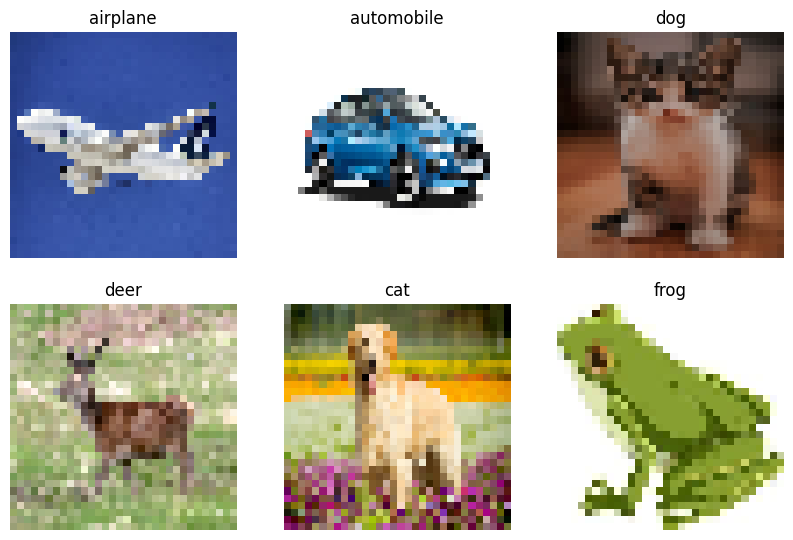

In [20]:
plt.figure(figsize=(10, 10))
for images in predict_ds:
    for i in range(min(6, probabilities.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = get_predicted_class(probabilities[i])
        plt.title(predicted_class)
        plt.axis("off")

## Conclusion

The most impactful contribution of the paper is not the novel architecture, but
the idea that hierarchical ViTs trained with no attention can perform quite well. This
opens up the question of how essential attention is to the performance of ViTs.

For curious minds, we would suggest reading the
[ConvNexT](https://arxiv.org/abs/2201.03545) paper which attends more to the training
paradigms and architectural details of ViTs rather than providing a novel architecture
based on attention.

Acknowledgements:

- We would like to thank [PyImageSearch](https://pyimagesearch.com) for providing us with
resources that helped in the completion of this project.
- We would like to thank [JarvisLabs.ai](https://jarvislabs.ai/) for providing with the
GPU credits.
- We would like to thank [Manim Community](https://www.manim.community/) for the manim
library.
- A personal note of thanks to [Puja Roychowdhury](https://twitter.com/pleb_talks) for
helping us with the Learning Rate Schedule.

**Example available on HuggingFace**

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-ShiftViT-brightgreen)](https://huggingface.co/keras-io/shiftvit) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Space-ShiftViT-brightgreen)](https://huggingface.co/spaces/keras-io/shiftvit) |